<a href="https://colab.research.google.com/github/abdullah90907/g-thinkerq-demo/blob/main/G_ThinkerQ_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from collections import deque

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


In [3]:
n = 500
G = nx.barabasi_albert_graph(n, 3, seed=42)

# Plant a K7 clique so we always have nice matches to highlight
clique_size = 7
clique_nodes = list(range(clique_size))
for i in range(clique_size):
    for j in range(i + 1, clique_size):
        G.add_edge(clique_nodes[i], clique_nodes[j])

# Precompute layout once for fast visualization later
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

print(f"✅ Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"   (Planted K{clique_size} guarantees triangles + 4-cliques)")

✅ Graph created: 500 nodes, 1500 edges
   (Planted K7 guarantees triangles + 4-cliques)


In [4]:
def decompose_query(G, pattern, query_id):
    """Break query into ~20 independent tasks (vertex chunks)."""
    vertices = list(G.nodes())
    num_tasks = 20
    chunk_size = max(1, len(vertices) // num_tasks)
    tasks = []
    for i in range(0, len(vertices), chunk_size):
        chunk = vertices[i:i + chunk_size]
        task = {
            'id': i // chunk_size,
            'query_id': query_id,
            'pattern': pattern,
            'vertices': chunk,
            'progress': 0,
            'total': len(chunk),
            'matches': []
        }
        tasks.append(task)
    return tasks

print("✅ decompose_query() defined (20 tasks per query)")

✅ decompose_query() defined (20 tasks per query)


In [5]:
def process_task_step(task):
    """Process ONE vertex in the task. Returns number of steps completed (1 or 0)."""
    if task['progress'] >= task['total']:
        return 0

    v = task['vertices'][task['progress']]
    matches = []
    neigh = list(G.neighbors(v))

    if task['pattern'] == 'triangle':
        for ii in range(len(neigh)):
            for jj in range(ii + 1, len(neigh)):
                u, w = neigh[ii], neigh[jj]
                if G.has_edge(u, w):
                    tri = tuple(sorted([v, u, w]))
                    matches.append(tri)

    elif task['pattern'] == 'k4':
        for ii in range(len(neigh)):
            for jj in range(ii + 1, len(neigh)):
                for kk in range(jj + 1, len(neigh)):
                    u, w, z = neigh[ii], neigh[jj], neigh[kk]
                    if (G.has_edge(u, w) and G.has_edge(u, z) and G.has_edge(w, z)):
                        kfour = tuple(sorted([v, u, w, z]))
                        matches.append(kfour)

    task['matches'].extend(matches)
    task['progress'] += 1
    return 1  # one step completed

print("✅ process_task_step() defined")

✅ process_task_step() defined


In [6]:
MAX_CORES = 5
pending_tasks = deque()
active_tasks = []
query_results = {}

def submit_query(query_id, pattern):
    """Submit a query → decompose → append tasks to FIFO queue."""
    if query_id in query_results:
        print(f"⚠️ Query {query_id} already submitted.")
        return
    tasks = decompose_query(G, pattern, query_id)
    for t in tasks:
        pending_tasks.append(t)
    total_steps = sum(t['total'] for t in tasks)
    query_results[query_id] = {
        'pattern': pattern,
        'matches': set(),
        'total_steps': total_steps,
        'completed_steps': 0,
        'progress': 0.0
    }
    print(f"🚀 Query {query_id} submitted → {pattern} (20 tasks, {total_steps} total steps)")

def run_scheduler(max_ticks=1000, sleep_time=0.012):
    """FIFO scheduler simulating 5 cores. Live tqdm + per-query progress."""
    tick = 0
    with tqdm(total=max_ticks, desc="🕒 Scheduler ticks (5 simulated cores)") as pbar:
        while (pending_tasks or active_tasks) and tick < max_ticks:
            # Fill active tasks from FIFO queue (fairness)
            while len(active_tasks) < MAX_CORES and pending_tasks:
                new_task = pending_tasks.popleft()
                active_tasks.append(new_task)

            # Advance every active task (parallel simulation)
            i = len(active_tasks) - 1
            while i >= 0:
                task = active_tasks[i]
                steps_done = process_task_step(task)
                if steps_done > 0:
                    qid = task['query_id']
                    query_results[qid]['completed_steps'] += steps_done
                    query_results[qid]['progress'] = (
                        query_results[qid]['completed_steps'] / query_results[qid]['total_steps'] * 100
                    )
                    if task['progress'] >= task['total']:
                        # Task finished → collect unique matches
                        for m in task['matches']:
                            query_results[qid]['matches'].add(m)
                        del active_tasks[i]
                i -= 1

            tick += 1
            pbar.update(1)
            time.sleep(sleep_time)   # live feel (adjust for speed)

    # Final summary
    print("\n✅ Scheduler finished!")
    for qid, res in query_results.items():
        print(f"   Query {qid} ({res['pattern']}): {res['progress']:.1f}% | "
              f"{len(res['matches'])} unique matches found")

print("✅ Scheduler ready (FIFO fairness + 5-core limit)")

✅ Scheduler ready (FIFO fairness + 5-core limit)


In [7]:
# ------------------- Submit queries online -------------------
submit_query(1, 'triangle')

time.sleep(0.4)   # simulate real online arrival delay

submit_query(2, 'k4')

# ------------------- Process -------------------
run_scheduler(max_ticks=1000, sleep_time=0.012)

print("\n🎉 All queries processed! Try adding more queries below and re-running the scheduler cell.")
# Example of adding a third query while "online":
# submit_query(3, 'triangle')
# run_scheduler()

🚀 Query 1 submitted → triangle (20 tasks, 500 total steps)
🚀 Query 2 submitted → k4 (20 tasks, 500 total steps)


🕒 Scheduler ticks (5 simulated cores):  20%|██        | 200/1000 [00:02<00:10, 78.81it/s]


✅ Scheduler finished!
   Query 1 (triangle): 100.0% | 239 unique matches found
   Query 2 (k4): 100.0% | 45 unique matches found

🎉 All queries processed! Try adding more queries below and re-running the scheduler cell.


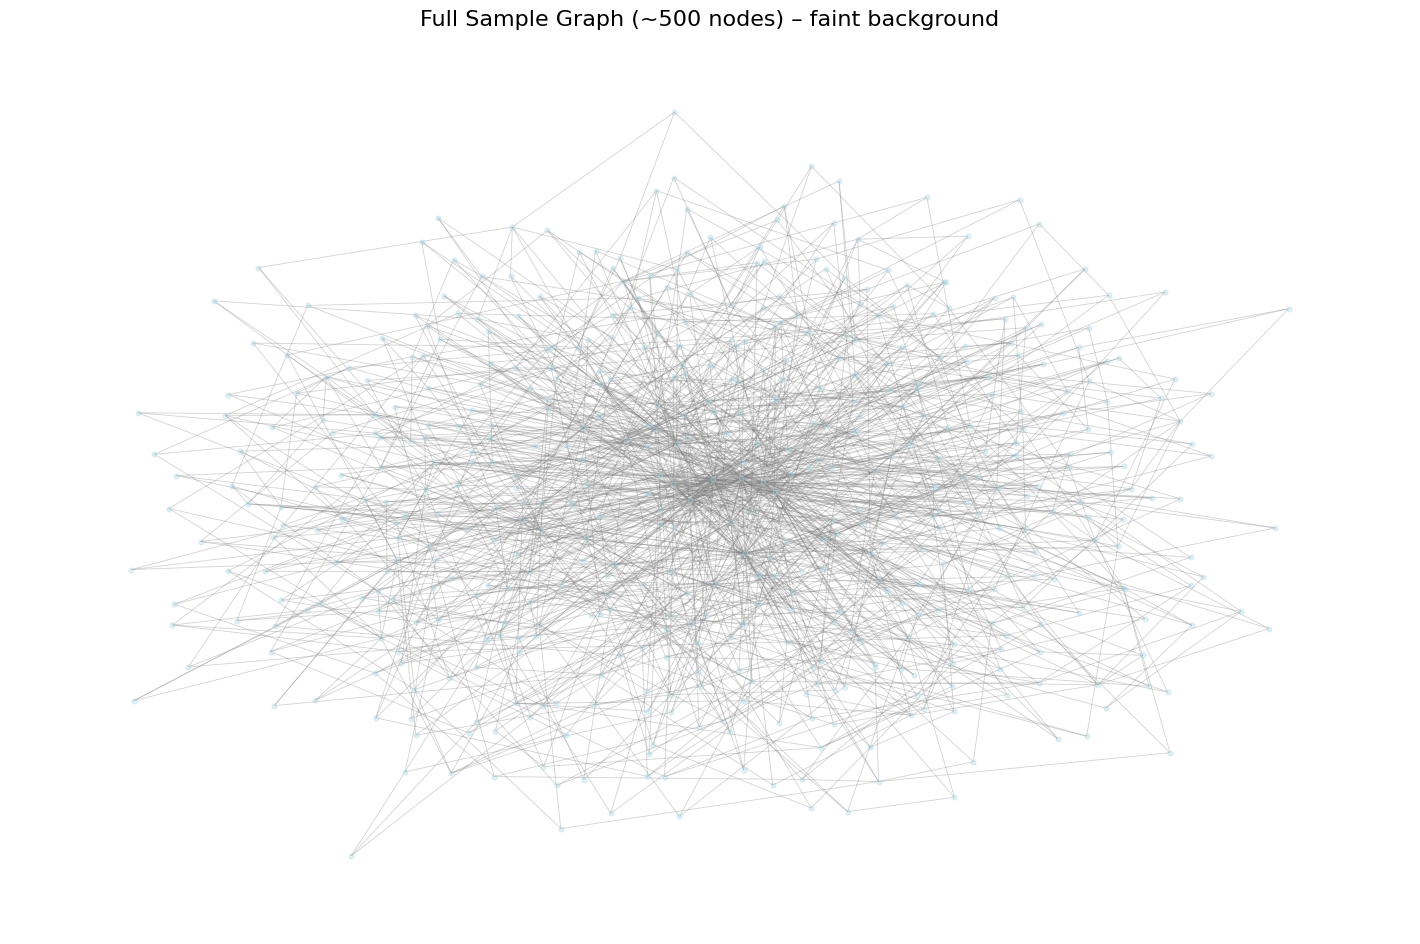

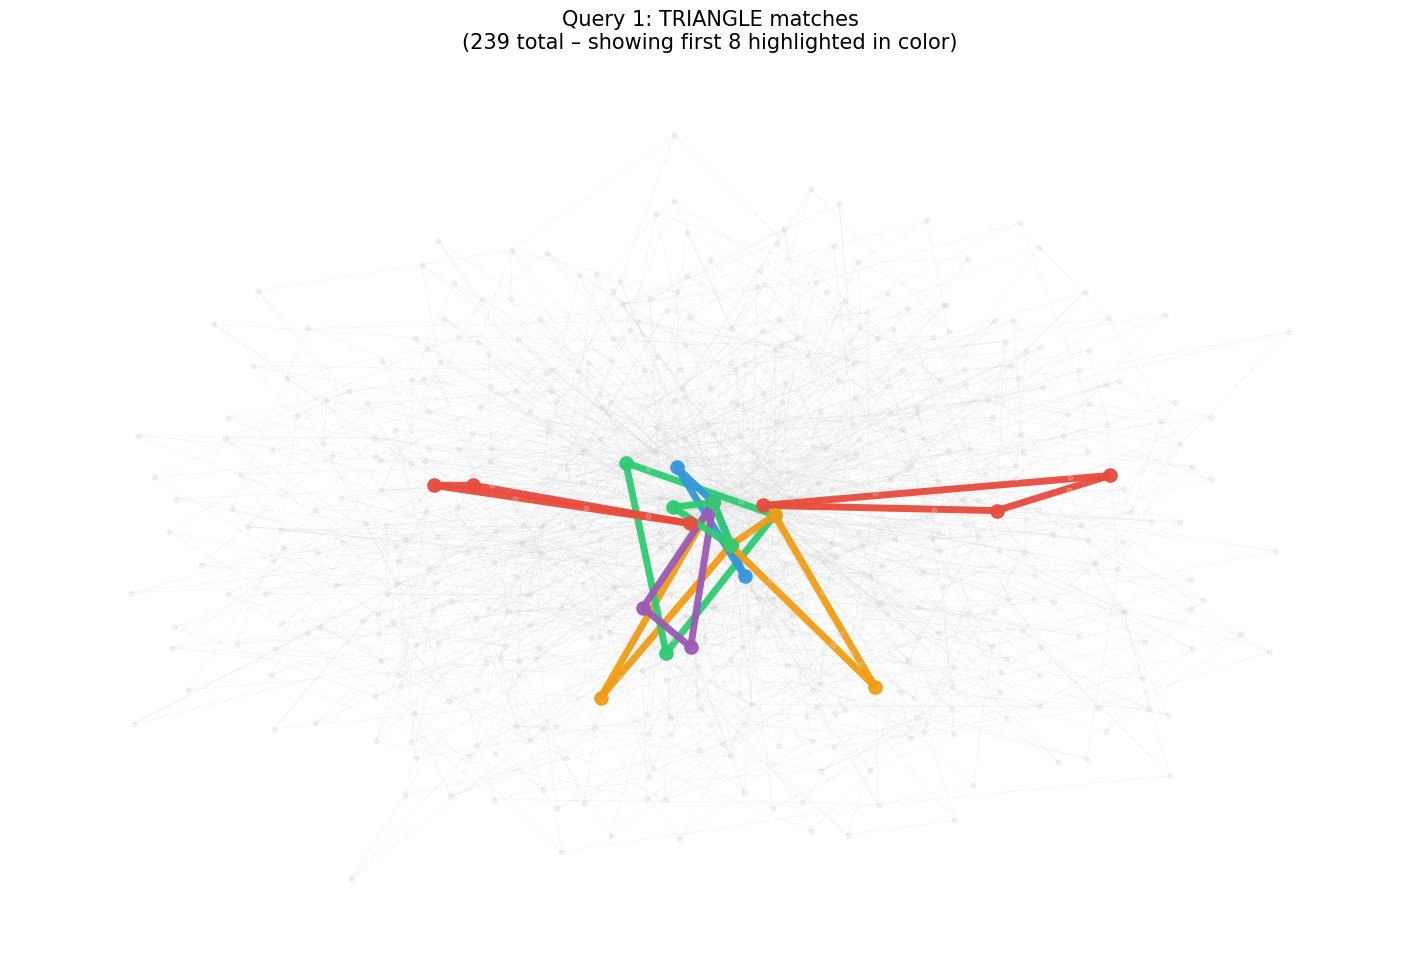

Query 1 (triangle): 239 unique subgraphs found


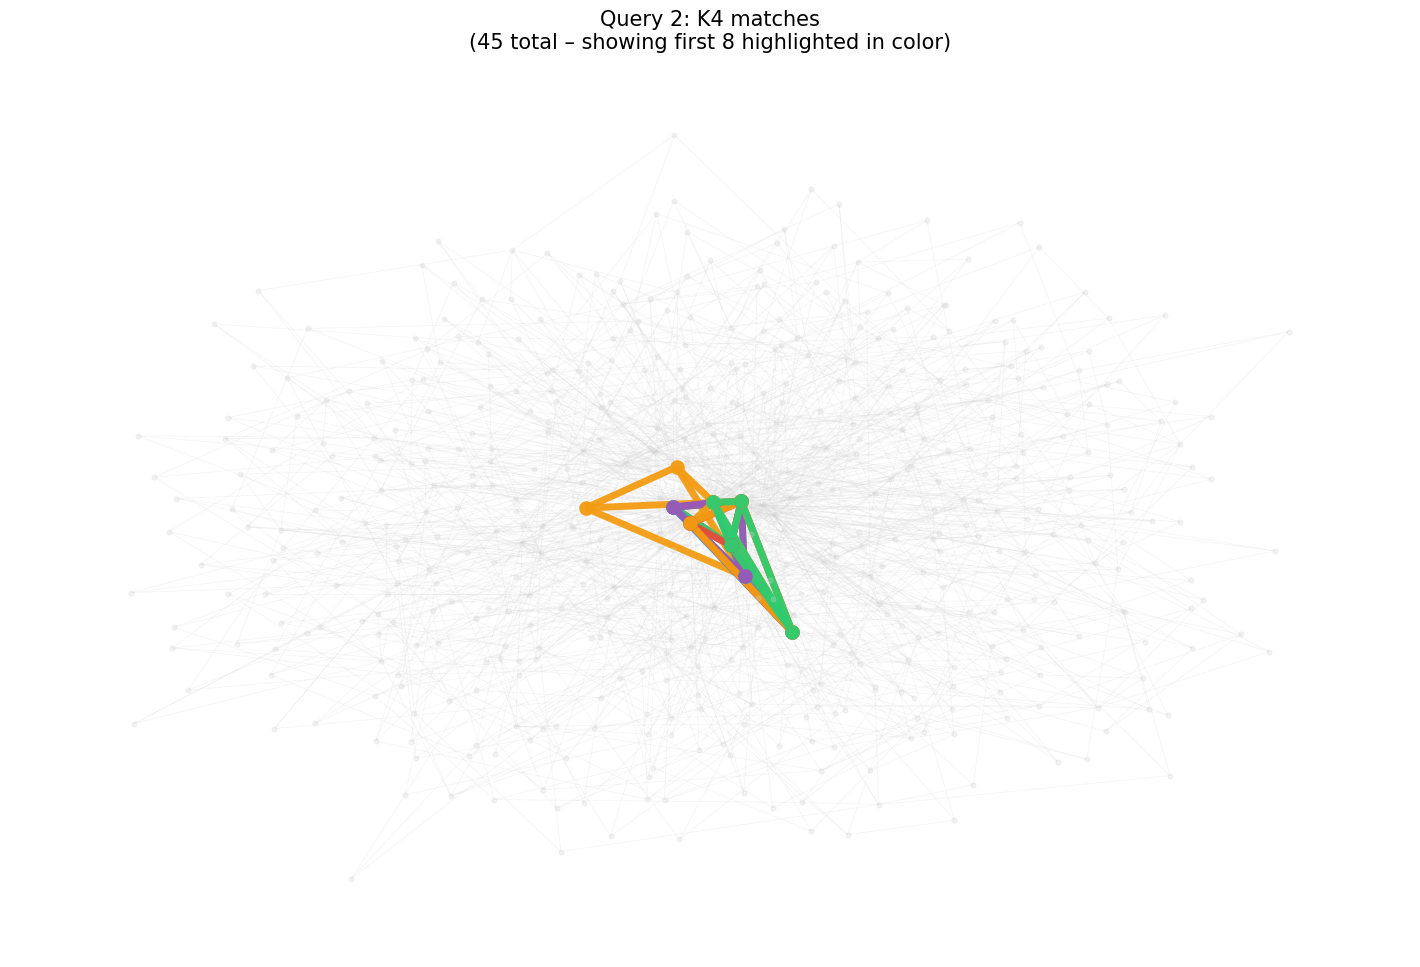

Query 2 (k4): 45 unique subgraphs found


In [8]:
# Base graph (faint)
plt.figure(figsize=(14, 9))
nx.draw(G, pos, node_size=12, node_color='lightblue', alpha=0.35,
        edge_color='gray', width=0.6)
plt.title("Full Sample Graph (~500 nodes) – faint background", fontsize=16)
plt.show()

# Highlighted matches for each query (limit to 8 per query for clarity)
colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db', '#9b59b6']

for qid, res in sorted(query_results.items()):
    if len(res['matches']) == 0:
        print(f"No matches for Query {qid} (unlikely)")
        continue

    plt.figure(figsize=(14, 9))
    # faint background again
    nx.draw(G, pos, node_size=12, node_color='lightgray', alpha=0.25,
            edge_color='lightgray', width=0.5)

    # highlight up to 8 matches
    highlighted = list(res['matches'])[:8]
    for idx, match in enumerate(highlighted):
        sg = G.subgraph(match)
        col = colors[idx % len(colors)]
        nx.draw(sg, pos,
                node_size=90,
                node_color=col,
                edge_color=col,
                width=5,
                alpha=0.95)

    plt.title(f"Query {qid}: {res['pattern'].upper()} matches\n"
              f"({len(res['matches'])} total – showing first 8 highlighted in color)",
              fontsize=15)
    plt.show()

    print(f"Query {qid} ({res['pattern']}): {len(res['matches'])} unique subgraphs found")